S5 CSE Beta


---

EBY J KAVUNGAL

JOYAL GEORGE JOSEPH

JOES JACOB PAUL

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joyal22","key":"99fd809a3f10b091c5b63e176f7e17df"}'}

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 651M/658M [00:06<00:00, 124MB/s]
100% 658M/658M [00:06<00:00, 104MB/s]


In [3]:
!unzip plantdisease.zip -d plant_disease

Streaming output truncated to the last 5000 lines.
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plant_disease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plant_

Epoch 1, Loss: 0.1431
Epoch 2, Loss: 0.0184


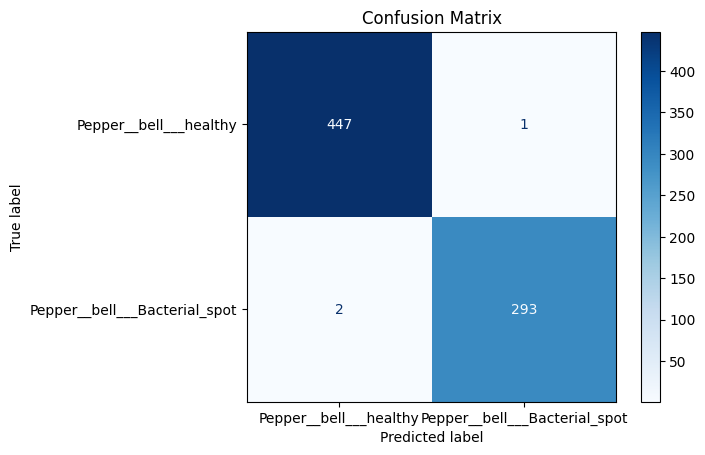

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import os
import matplotlib.pyplot as plt

# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define a function to filter valid image files and ignore .ipynb_checkpoints
def is_valid_file(path):
    valid_extensions = {'.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp'}
    return (os.path.splitext(path)[1].lower() in valid_extensions
            and '.ipynb_checkpoints' not in path)

# Custom dataset class
class CustomImageFolder(Dataset):
    def __init__(self, root_dir, transform=None, is_valid_file=None):
        self.root_dir = root_dir
        self.transform = transform
        self.is_valid_file = is_valid_file
        self.image_paths = []
        self.labels = []

        for label in os.listdir(root_dir):
            class_path = os.path.join(root_dir, label)
            if os.path.isdir(class_path):
                for file_name in os.listdir(class_path):
                    file_path = os.path.join(class_path, file_name)
                    if is_valid_file(file_path):
                        self.image_paths.append(file_path)
                        self.labels.append(label)

        self.class_to_idx = {cls: idx for idx, cls in enumerate(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, cls))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.class_to_idx[self.labels[idx]]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

# Path to your dataset directory
data_dir = '/content/Data'

# Load dataset using the custom class
dataset = CustomImageFolder(data_dir, transform=train_transforms, is_valid_file=is_valid_file)

# Split dataset into training (70%) and testing (30%)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Apply validation transformations to the test dataset
test_dataset.dataset.transform = val_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load and modify ResNet-18 model
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
num_classes = len(dataset.class_to_idx)
model.fc = nn.Linear(num_features, num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs =
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluate model and compute confusion matrix
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=list(dataset.class_to_idx.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'plant_disease_small.pth')

# Prediction function
def predict_image(image_path, model):
    model.eval()
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        class_idx = predicted.item()

    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
    return idx_to_class[class_idx]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 88.8MB/s]


Epoch 1, Loss: 0.4390
Epoch 2, Loss: 0.2026


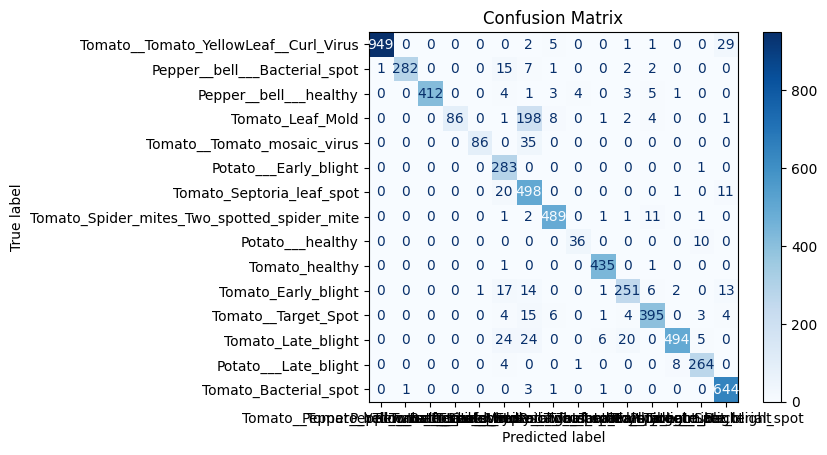

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import os
import matplotlib.pyplot as plt

# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define a function to filter valid image files and ignore .ipynb_checkpoints
def is_valid_file(path):
    valid_extensions = {'.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp'}
    return (os.path.splitext(path)[1].lower() in valid_extensions
            and '.ipynb_checkpoints' not in path)

# Custom dataset class
class CustomImageFolder(Dataset):
    def __init__(self, root_dir, transform=None, is_valid_file=None):
        self.root_dir = root_dir
        self.transform = transform
        self.is_valid_file = is_valid_file
        self.image_paths = []
        self.labels = []

        for label in os.listdir(root_dir):
            class_path = os.path.join(root_dir, label)
            if os.path.isdir(class_path):
                for file_name in os.listdir(class_path):
                    file_path = os.path.join(class_path, file_name)
                    if is_valid_file(file_path):
                        self.image_paths.append(file_path)
                        self.labels.append(label)

        self.class_to_idx = {cls: idx for idx, cls in enumerate(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, cls))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.class_to_idx[self.labels[idx]]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

# Path to your dataset directory
data_dir = '/content/plant_disease/PlantVillage'

# Load dataset using the custom class
dataset = CustomImageFolder(data_dir, transform=train_transforms, is_valid_file=is_valid_file)

# Split dataset into training (70%) and testing (30%)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Apply validation transformations to the test dataset
test_dataset.dataset.transform = val_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load and modify ResNet-18 model
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
num_classes = len(dataset.class_to_idx)
model.fc = nn.Linear(num_features, num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 2
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluate model and compute confusion matrix
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=list(dataset.class_to_idx.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'plant_disease.pth')

# Prediction function
def predict_image(image_path, model):
    model.eval()
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        class_idx = predicted.item()

    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
    return idx_to_class[class_idx]
